**Classes selected for this assignment**
1. Border collie
2. Irish terrier
3. Tibetan terrier
4. Scottish deerhound

In [1]:
import cv2
import os
import numpy as np

**Prepare Dataset with Edge Histogram** 

Convert Images to Edge Histograms

In [2]:
# Define paths to each class
base_path = r"C:\Users\ADMIN\Desktop\Assigment2\Images"

classes = ["n02106166-Border_collie", "n02093991-Irish_terrier", "n02097474-Tibetan_terrier", "n02092002-Scottish_deerhound"]

edge_histograms = []  # To store histograms
labels = []  # To store labels

def create_edge_histogram(image_path):
    # Load image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Apply Canny edge detection
    edges = cv2.Canny(image, 100, 200)

    # Calculate histogram of edge-detected image
    hist = cv2.calcHist([edges], [0], None, [256], [0, 256])

    # Normalize the histogram
    hist = cv2.normalize(hist, hist).flatten()
    return hist

for class_name in classes:
    class_path = os.path.join(base_path, class_name)
    for image_file in os.listdir(class_path):
        image_path = os.path.join(class_path, image_file)
        histogram = create_edge_histogram(image_path)
        edge_histograms.append(histogram)
        labels.append(class_name)

# Convert to numpy arrays for easier processing
X = np.array(edge_histograms)
y = np.array(labels)

# Save processed dataset 
np.save("edge_histograms.npy", X)
np.save("labels.npy", y)

**Split Dataset** 

Training/Test Split: Divide the dataset into an 80% training set and a 20% test set

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
# Load the saved dataset if not already in memory
X = np.load("edge_histograms.npy")
y = np.load("labels.npy")

# Perform an 80/20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Save split datasets
np.save("X_train.npy", X_train)
np.save("X_test.npy", X_test)
np.save("y_train.npy", y_train)
np.save("y_test.npy", y_test)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Training set size: 605
Test set size: 152


**Standardize the Dataset**

Standardize the training data using StandardScaler to scale features to have zero mean and unit variance.

In [5]:
from sklearn.preprocessing import StandardScaler

In [6]:
# Load the split datasets (if not already in memory)
X_train = np.load("X_train.npy")
X_test = np.load("X_test.npy")

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data, then transform both training and test sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save the standardized datasets
np.save("X_train_scaled.npy", X_train_scaled)
np.save("X_test_scaled.npy", X_test_scaled)

print("Standardization complete.")

Standardization complete.


**Performance comparison**

Train Models on the 4-Class Classification Problem

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

**Classification methods**

1. Naive bayes
2. Decision tree
3. Random forest classifier

In [8]:
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score


# Initialize classifiers
naive_bayes = GaussianNB()
decision_tree = DecisionTreeClassifier(max_depth=10)
random_forest = RandomForestClassifier()


Stratified 5-Fold Cross-Validation: stratified 5-fold cross-validation on each model using StratifiedKFold

In [9]:
# Stratified 5-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Function to evaluate classifiers using cross-validation
def evaluate_classifier(clf, X, y):
    accuracies = cross_val_score(clf, X, y, cv=skf, scoring='accuracy')
    mean_accuracy = np.mean(accuracies)
    return mean_accuracy

# Evaluate each classifier
nb_accuracy = evaluate_classifier(naive_bayes, X, y)
dt_accuracy = evaluate_classifier(decision_tree, X, y)
rf_accuracy = evaluate_classifier(random_forest, X, y)

print(f'Naive Bayes Mean Accuracy: {nb_accuracy}')
print(f'Decision Tree Mean Accuracy: {dt_accuracy}')
print(f'Random Forest Mean Accuracy: {rf_accuracy}')


Naive Bayes Mean Accuracy: 0.33951725339839667
Decision Tree Mean Accuracy: 0.32761415127222027
Random Forest Mean Accuracy: 0.3078075984663646


**Plot confusion matrix**

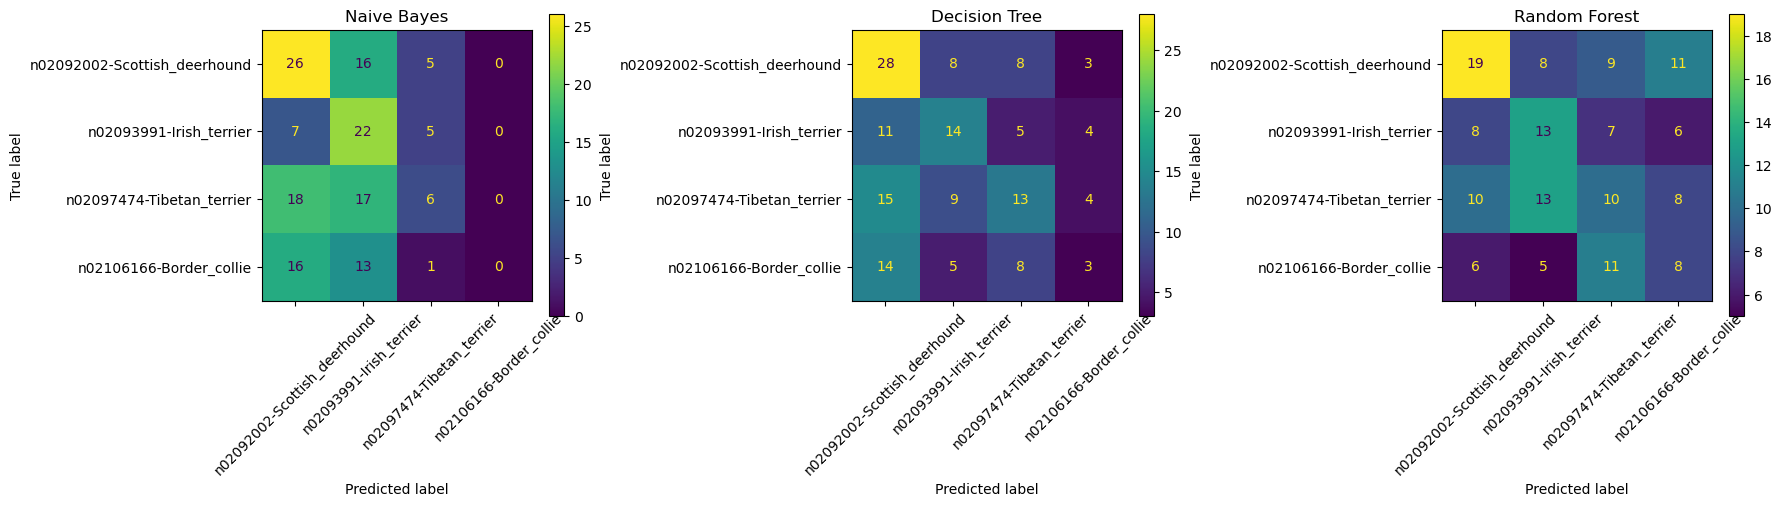

In [10]:
# Fit each classifier to the training data
naive_bayes.fit(X_train, y_train)
decision_tree.fit(X_train, y_train)
random_forest.fit(X_train, y_train)

# Generate predictions
nb_predictions = naive_bayes.predict(X_test)
dt_predictions = decision_tree.predict(X_test)
rf_predictions = random_forest.predict(X_test)

# plot the confusion matrices
from sklearn.metrics import ConfusionMatrixDisplay

# Set a larger figure size for better readability
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot confusion matrices for each classifier with adjustments
ConfusionMatrixDisplay.from_estimator(naive_bayes, X_test, y_test, ax=axes[0])
axes[0].set_title("Naive Bayes")
axes[0].tick_params(axis='x', labelrotation=45, labelsize=10)

ConfusionMatrixDisplay.from_estimator(decision_tree, X_test, y_test, ax=axes[1])
axes[1].set_title("Decision Tree")
axes[1].tick_params(axis='x', labelrotation=45, labelsize=10)

ConfusionMatrixDisplay.from_estimator(random_forest, X_test, y_test, ax=axes[2])
axes[2].set_title("Random Forest")
axes[2].tick_params(axis='x', labelrotation=45, labelsize=10)

plt.tight_layout()
plt.show()

Based on the confusion matrix, Decision Tree is the best method. It has the most prominent diagonal and the least spread of values off the diagonal therefore indicating better performance.

Accuracy and F-Measure Computations

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Function to calculate metrics
def compute_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    return accuracy, precision, recall, f1

# Calculate metrics for each classifier
nb_metrics = compute_metrics(y_test, nb_predictions)
dt_metrics = compute_metrics(y_test, dt_predictions)
rf_metrics = compute_metrics(y_test, rf_predictions)

print(f'Naive Bayes: Accuracy: {nb_metrics[0]}, Precision: {nb_metrics[1]}, Recall: {nb_metrics[2]}, F1: {nb_metrics[3]}')
print(f'Decision Tree: Accuracy: {dt_metrics[0]}, Precision: {dt_metrics[1]}, Recall: {dt_metrics[2]}, F1: {dt_metrics[3]}')
print(f'Random Forest: Accuracy: {rf_metrics[0]}, Precision: {rf_metrics[1]}, Recall: {rf_metrics[2]}, F1: {rf_metrics[3]}')


Naive Bayes: Accuracy: 0.35526315789473684, Precision: 0.2875618039831801, Recall: 0.35526315789473684, F1: 0.29334224854331836
Decision Tree: Accuracy: 0.3815789473684211, Precision: 0.3597381935230232, Recall: 0.3815789473684211, F1: 0.3604684141182997
Random Forest: Accuracy: 0.32894736842105265, Precision: 0.33193804965530793, Recall: 0.32894736842105265, F1: 0.3295125106408452


C:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1. Naive Bayes had better accuracy.
2. After calculting  F-measure, Naive Bayes had better F-measure. 

In [12]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score

**Model Selection with SVM (Binary Classification)**

Classes used: Border_collie & Scottish_deerhound


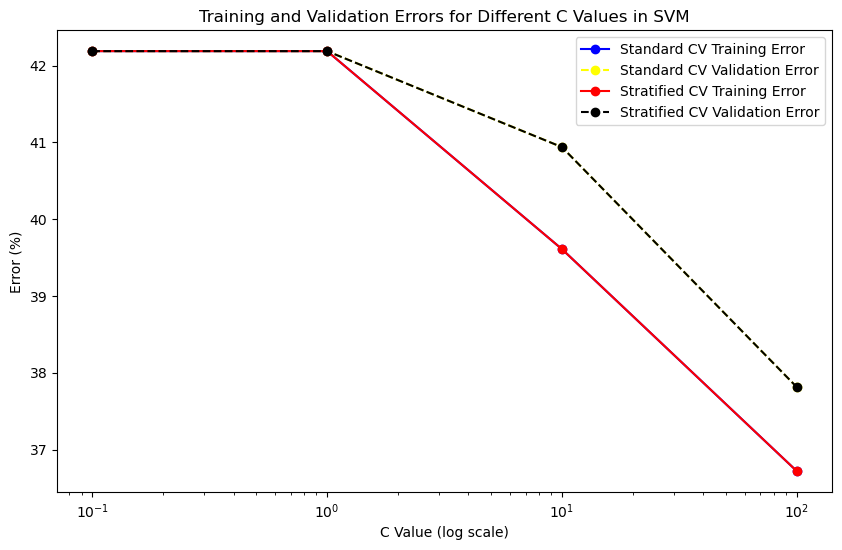

Best C value: 100 with stratified CV validation error of 37.81%
Test error for best C value: 65.79%


In [14]:
# Select two classes
two_class_indices = (y_train == 'n02093991-Irish_terrier') | (y_train == 'n02092002-Scottish_deerhound')
X_train_two_class = X_train[two_class_indices]
y_train_two_class = y_train[two_class_indices]

# Define the range of C values
C_values = [0.1, 1, 10, 100]

# Initialize lists to store errors
standard_cv_train_errors = []
standard_cv_val_errors = []
stratified_cv_train_errors = []
stratified_cv_val_errors = []

# Perform standard and stratified 5-fold cross-validation for each C value
for C in C_values:
    svm = SVC(C=C, kernel='linear')
    
    # Standard 5-fold cross-validation for validation error
    standard_cv_val_error = 1 - cross_val_score(svm, X_train_two_class, y_train_two_class, cv=5, scoring='accuracy').mean()
    standard_cv_val_errors.append(standard_cv_val_error * 100)
    
    # Manually calculate standard 5-fold training error
    standard_train_errors = []
    skf = StratifiedKFold(n_splits=5)
    for train_index, val_index in skf.split(X_train_two_class, y_train_two_class):
        X_tr, X_val = X_train_two_class[train_index], X_train_two_class[val_index]
        y_tr, y_val = y_train_two_class[train_index], y_train_two_class[val_index]
        svm.fit(X_tr, y_tr)
        standard_train_errors.append(1 - accuracy_score(y_tr, svm.predict(X_tr)))
    standard_cv_train_errors.append(np.mean(standard_train_errors) * 100)

    # Stratified 5-fold cross-validation for training and validation errors
    stratified_train_errors = []
    stratified_val_errors = []
    for train_index, val_index in skf.split(X_train_two_class, y_train_two_class):
        X_tr, X_val = X_train_two_class[train_index], X_train_two_class[val_index]
        y_tr, y_val = y_train_two_class[train_index], y_train_two_class[val_index]
        svm.fit(X_tr, y_tr)
        stratified_train_errors.append(1 - accuracy_score(y_tr, svm.predict(X_tr)))
        stratified_val_errors.append(1 - accuracy_score(y_val, svm.predict(X_val)))
    stratified_cv_train_errors.append(np.mean(stratified_train_errors) * 100)
    stratified_cv_val_errors.append(np.mean(stratified_val_errors) * 100)

# Plot the error curves
plt.figure(figsize=(10, 6))
plt.plot(C_values, standard_cv_train_errors, label='Standard CV Training Error', marker='o', color='blue')
plt.plot(C_values, standard_cv_val_errors, label='Standard CV Validation Error', marker='o', linestyle='--', color='yellow')
plt.plot(C_values, stratified_cv_train_errors, label='Stratified CV Training Error', marker='o', color='red')
plt.plot(C_values, stratified_cv_val_errors, label='Stratified CV Validation Error', marker='o', linestyle='--', color='black')
plt.xscale('log')
plt.xlabel('C Value (log scale)')
plt.ylabel('Error (%)')
plt.title('Training and Validation Errors for Different C Values in SVM')
plt.legend()
plt.show()

# Choose the best C based on lowest stratified validation error
best_C_index = np.argmin(stratified_cv_val_errors)
best_C = C_values[best_C_index]
print(f"Best C value: {best_C} with stratified CV validation error of {stratified_cv_val_errors[best_C_index]:.2f}%")

# Retrain on full training set with best C and evaluate on the test set
best_svm = SVC(C=best_C, kernel='linear')
best_svm.fit(X_train_two_class, y_train_two_class)
test_error = 1 - accuracy_score(y_test, best_svm.predict(X_test))
print(f"Test error for best C value: {test_error * 100:.2f}%")